# Figure out the magnitude limit of CPM method.

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from tess_stars2px import tess_stars2px_function_entry
import eleanor
import tess_rotation as tr
import starspot as ss
import starry
from contextlib import contextmanager

import warnings
warnings.filterwarnings('ignore')

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

Define functions for injection and recovery.

In [2]:
# Calculate counts for a star of a certain magnitude
def mag_to_counts(mag, seconds):
    """
    Convert stellar magnitude to electron counts.
    
    "15,000 e−/s for a star of m = 10: thus, a star of m = 5 will create 3 × 106 electrons in a two-second exposure"
    10 x fainter is a magnitude increase of 2.5 
    
    F2/F1 approx 2.5^(delta m)
    delta m = 1
    F2/F1 = 2.5
    
    delta m = log(F2/F1)/log(2.5)
    for F2/F1 = 10, delta m = 2.5
    
    For a change of 1 mag, the change in brightness is 2.5.
    For a change of 2.5 mag, the change in brightness is 10.
    For a change of 5 mag, the change in brightness is 100.
    """
    m = 10
    e = 15000
    delta_m = m - mag
    factor = 2.51**delta_m
    counts_per_sec = e * factor
    return counts_per_sec * seconds

Instantiate injection class.

In [3]:
ticid = 765143490
tesscut_path = "/Users/rangus/projects/TESS-rotation/data/TESScut/"
star = tr.InjectStar(ticid, tesscut_path, upper_sector_limit=14)

Finding the sectors that star was observed in.
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_bkg.fits with expected size 79384320. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc.fits with expected size 158880960. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2_tess_v2_pm.txt with expected size 239290. [astroquery.query]
Found sectors [ 1  2  4  5  6  7  8  9 10 11 12]
Loading time arrays
sector 1
sector 2
sector 4
sector 5
sector 6
sector 7
sector 8
sector 9
sector 10
sector 11
sector 12


In [4]:
magnitude = 15
baseline = mag_to_counts(magnitude, 2)
print(baseline, baseline*.01)
period, amplitude = 50, baseline*.01  # 1% amplitude.

301.1290453376505 3.011290453376505


Pre-computing some matrices... Done.
Compiling `flux`... Done.
Pre-computing some matrices... Done.
Compiling `flux`... Done.


1.5035495512492443 %
1.799681269733663 %


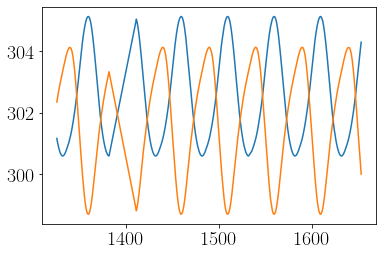

In [5]:
star.generate_signal(period, amplitude, baseline)
plt.plot(star.time_array, star.signal)
print((max(star.signal) - min(star.signal))/baseline*100, "%")
star.generate_signal(period, amplitude, baseline)
plt.plot(star.time_array, star.signal)
print((max(star.signal) - min(star.signal))/baseline*100, "%")

In [6]:
def loop(period, amplitude, baseline, nsamps=10):
    true_periods, recovered_periods, true_amp = [np.zeros(nsamps) for i in range(3)]

    for i in range(nsamps):
        print(i, "of", nsamps)
        
        print("Injecting...")
        with suppress_stdout():
            star.generate_signal(period, amplitude, baseline)
            star.inject_signal()
        plt.plot(star.time_array, star.signal)

        print("Recovering...")
        with suppress_stdout():
            time_cpm, flux_cpm = star.CPM_recover()

        #  Stitch
        time, flux, flux_err = tr.stitch_light_curve(ticid, time_cpm, flux_cpm)

        #  Measure
        p = np.polyfit(time, flux, 1)
        rotate = ss.RotationModel(time, flux-np.polyval(p, time), flux_err)
        ls_period = rotate.ls_rotation(max_period=200.)

        true_periods[i] = period
        recovered_periods[i] = ls_period
        true_amp[i] = (max(star.signal) - min(star.signal))/baseline*100
        
#         fig = plt.figure(figsize=(16, 8), dpi=200)
#         ax1 = fig.add_subplot(211)
#         xs = np.linspace(min(time), max(time), 1000)
#         ax1.errorbar(time, flux-np.polyval(p, time), yerr=flux_err, fmt="k.", alpha=.2, label="$\mathrm{Recovered~signal}$", rasterized=True)
#         ax1.legend(fontsize=18)
#         ax1.set_xlabel("$\mathrm{Time~[days]}$")
#         ax1.set_ylabel("$\mathrm{Flux~[arbitrary~units]}$");
#         ax2 = fig.add_subplot(212)
#         ax2.plot(1./rotate.freq, rotate.power)
#         ax2.set_xlabel("$\mathrm{Period~[days]}$")
#         ax2.set_ylabel("$\mathrm{Power}$");
#         plt.tight_layout()
#         plt.show()
    
    return true_periods, recovered_periods

In [ ]:
true50, recovered50 = loop(period, amplitude, baseline, nsamps=20)

Pre-computing some matrices... Done.
Compiling `flux`... Done.


0 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
65it [00:00, 91.17it/s, logp=4.253984e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: 523.0482306743285 -> 4253.984211473586
Pre-computing some matrices... Done.
Compiling `flux`... Done.


1 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
90it [00:00, 699.45it/s, logp=4.274759e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.9355372281275 -> 4274.758839455078
Pre-computing some matrices... Done.
Compiling `flux`... Done.


2 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
134it [00:00, 709.93it/s, logp=4.242238e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.5374944900298 -> 4242.238300740322
Pre-computing some matrices... Done.
Compiling `flux`... Done.


3 of 20
Injecting...
Recovering...


In [ ]:
relative = true50/recovered50
correct_mask = (.9 < relative) & (relative < 1.1)
print(len(true50[correct_mask]))

In [ ]:
true100, recovered100 = loop(100, amplitude, baseline, nsamps=20)

In [ ]:
true150, recovered150 = loop(150, amplitude, baseline, nsamps=20)

In [ ]:
true200, recovered200 = loop(200, amplitude, baseline, nsamps=20)

In [7]:
print(true, recovered)

[50. 50.] [88.77555097 89.40895618]


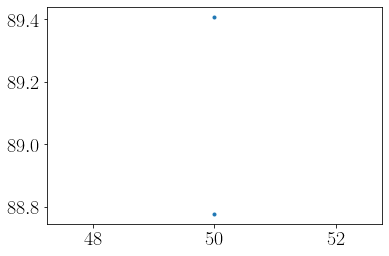

In [8]:
plt.plot(true, recovered, ".");